<a href="https://colab.research.google.com/github/dlgur1994/Hackerthon1_Aiffel/blob/main/jisu/aiffel_9_recruit_restaurant_visitor_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [118]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import skew
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 데이터 분석

## Load Data

In [67]:
air_reserve = pd.read_csv('/content/drive/MyDrive/Hackathon/data/air_reserve.csv.zip')
air_store_info = pd.read_csv('/content/drive/MyDrive/Hackathon/data/air_store_info.csv.zip')
hpg_reserve = pd.read_csv('/content/drive/MyDrive/Hackathon/data/hpg_reserve.csv.zip')
hpg_store_info = pd.read_csv('/content/drive/MyDrive/Hackathon/data/hpg_store_info.csv.zip')
air_visit_data = pd.read_csv('/content/drive/MyDrive/Hackathon/data/air_visit_data.csv.zip')
store_id_relation = pd.read_csv('/content/drive/MyDrive/Hackathon/data/store_id_relation.csv.zip')
date_info = pd.read_csv('/content/drive/MyDrive/Hackathon/data/date_info.csv.zip')
sample_submission = pd.read_csv('/content/drive/MyDrive/Hackathon/data/sample_submission.csv.zip')


## EDA

In [68]:
air_visit_data.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [69]:
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.69512,135.19785
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.69512,135.19785
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.69512,135.19785
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.69512,135.19785
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160


In [70]:
hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64367,139.66822
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64367,139.66822
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64367,139.66822
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64367,139.66822
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64367,139.66822


In [71]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [72]:
store_id_relation.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [73]:
sample_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [74]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


## Preprocess

In [75]:
# air 예약정보와 가게정보 합치기
air_mixed = pd.merge(air_reserve, air_store_info)
print("air 예약 수: ", len(air_reserve))
print("air 예약 중 가게 정보 있는 수: ", len(air_mixed))
air_mixed.head()

air 예약 수:  92378
air 예약 중 가게 정보 있는 수:  92378


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160


In [76]:
hpg_mixed = pd.merge(hpg_reserve, hpg_store_info)
print("hpg 예약 수: ", len(hpg_reserve))
print("hpg 예약 중 가게 정보 있는 수: ", len(hpg_mixed))
hpg_mixed.head()

hpg 예약 수:  2000320
hpg 예약 중 가게 정보 있는 수:  871308


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,French,Hyōgo-ken Kōbe-shi None,34.69211,135.19170
1,hpg_dac72789163a3f47,2016-01-02 12:00:00,2016-01-01 20:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.69211,135.19170
2,hpg_dac72789163a3f47,2016-01-03 19:00:00,2016-01-02 15:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.69211,135.19170
3,hpg_dac72789163a3f47,2016-01-06 12:00:00,2016-01-06 08:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.69211,135.19170
4,hpg_dac72789163a3f47,2016-01-10 17:00:00,2016-01-04 22:00:00,3,French,Hyōgo-ken Kōbe-shi None,34.69211,135.19170


In [77]:
# column name 공통되게 변경
air_mixed_new_columns = air_mixed.rename(columns = {"air_store_id":"id", "air_genre_name":"genre", "air_area_name": "area_name"}, inplace = False)
hpg_mixed_new_columns = hpg_mixed.rename(columns = {"hpg_store_id":"id", "hpg_genre_name":"genre", "hpg_area_name": "area_name"}, inplace = False)
mixed = pd.concat([air_mixed_new_columns, hpg_mixed_new_columns])
mixed

,id,visit_datetime,reserve_datetime,reserve_visitors,genre,area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160
...,...,...,...,...,...,...,...,...
871303,hpg_e106ddef2b137959,2017-04-24 18:00:00,2017-04-20 14:00:00,8,Japanese style,Tōkyō-to Chūō-ku None,35.68250,139.77362
871304,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,14,Japanese style,Tōkyō-to Chūō-ku None,35.68250,139.77362
871305,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,15,Japanese style,Tōkyō-to Chūō-ku None,35.68250,139.77362
871306,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-10 17:00:00,18,Japanese style,Tōkyō-to Chūō-ku None,35.68250,139.77362


In [78]:
# visit_datetime을 년월일로 변경
to_YMD = mixed.copy()
to_YMD['visit_date'] = to_YMD['visit_datetime'].str.slice(start=0, stop=10)
# to_YMD_df= to_YMD_df.drop(['visit_datetime', 'reserve_datetime'], axis='columns')
to_YMD

,id,visit_datetime,reserve_datetime,reserve_visitors,genre,area_name,latitude,longitude,visit_date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,2016-01-01
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,2016-01-01
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,2016-01-02
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,2016-01-02
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,2016-01-08
...,...,...,...,...,...,...,...,...,...
871303,hpg_e106ddef2b137959,2017-04-24 18:00:00,2017-04-20 14:00:00,8,Japanese style,Tōkyō-to Chūō-ku None,35.68250,139.77362,2017-04-24
871304,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,14,Japanese style,Tōkyō-to Chūō-ku None,35.68250,139.77362,2017-04-24
871305,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,15,Japanese style,Tōkyō-to Chūō-ku None,35.68250,139.77362,2017-04-24
871306,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-10 17:00:00,18,Japanese style,Tōkyō-to Chūō-ku None,35.68250,139.77362,2017-04-24


In [79]:
# 같은 날, 같은 식당의 reserve_visitors 합치기
merged = to_YMD.groupby(by=['visit_date', 'id', 'genre', 'area_name', 'latitude','longitude'], as_index=False).sum()
merged

,visit_date,id,genre,area_name,latitude,longitude,reserve_visitors
0,2016-01-01,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.65807,139.75160,3
1,2016-01-01,air_db4b38ebe7a7ceff,Dining bar,Ōsaka-fu Ōsaka-shi Shinmachi,34.67623,135.48606,9
2,2016-01-01,air_db80363d35f10926,Dining bar,Hokkaidō Asahikawa-shi 6 Jōdōri,43.77064,142.36482,5
3,2016-01-01,hpg_0168bd07d1336369,Grilled meat,Ōsaka-fu Suita-shi Enokichō,34.75262,135.49522,5
4,2016-01-01,hpg_0d302fa8c929ff48,Japanese style,Tōkyō-to Nerima-ku Hikawadai,35.75047,139.66841,3
...,...,...,...,...,...,...,...
590934,2017-05-31,hpg_ba19e6108767ebb6,Spain Bar/Italian Bar,Tōkyō-to Shinjuku-ku None,35.69138,139.70126,4
590935,2017-05-31,hpg_ca007a7397fff2a5,Italian,Ōsaka-fu Ōsaka-shi Awajimachi,34.68648,135.50417,29
590936,2017-05-31,hpg_d92cd8178ec0ece7,Japanese style,Tōkyō-to Chūō-ku None,35.68250,139.77362,15
590937,2017-05-31,hpg_ed715f88434d83db,Cafe,Tōkyō-to Shibuya-ku None,35.65921,139.69974,2


In [81]:
# air_visit_data 이용해서 워크인, 노쇼 등 확인
check_no_show = pd.merge(air_visit_data, with_day, left_on=['air_store_id', 'visit_date'], right_on=['id','visit_date'])
check_no_show2 = check_no_show.drop(['id', 'latitude', 'longitude', 'genre', 'area_name', 'day_of_week', 'holiday_flg'], axis='columns')
check_no_show2

,air_store_id,visit_date,visitors,reserve_visitors
0,air_35512c42db0868da,2016-02-27,6,12
1,air_ee3a01f0c71a769f,2016-01-04,61,2
2,air_ee3a01f0c71a769f,2016-01-08,21,3
3,air_ee3a01f0c71a769f,2016-01-09,57,25
4,air_ee3a01f0c71a769f,2016-01-10,32,5
...,...,...,...,...
28059,air_754ae581ad80cc9f,2017-04-14,3,2
28060,air_754ae581ad80cc9f,2017-04-15,39,20
28061,air_754ae581ad80cc9f,2017-04-19,6,6
28062,air_754ae581ad80cc9f,2017-04-22,47,28


In [86]:
# air_visit_data 이용해서 워크인, 노쇼 등 확인
check_no_show = pd.merge(air_visit_data, with_day, left_on=['air_store_id', 'visit_date'], right_on=['id','visit_date'])
check_no_show2 = check_no_show.drop(['id', 'latitude', 'longitude', 'genre', 'area_name', 'day_of_week', 'holiday_flg'], axis='columns')
check_no_show2

,air_store_id,visit_date,visitors,reserve_visitors
0,air_35512c42db0868da,2016-02-27,6,12
1,air_ee3a01f0c71a769f,2016-01-04,61,2
2,air_ee3a01f0c71a769f,2016-01-08,21,3
3,air_ee3a01f0c71a769f,2016-01-09,57,25
4,air_ee3a01f0c71a769f,2016-01-10,32,5
...,...,...,...,...
28059,air_754ae581ad80cc9f,2017-04-14,3,2
28060,air_754ae581ad80cc9f,2017-04-15,39,20
28061,air_754ae581ad80cc9f,2017-04-19,6,6
28062,air_754ae581ad80cc9f,2017-04-22,47,28


In [87]:
# 예약 인원과 실제 방문 고객의 수의 차이가 크기 때문에 예약에 관한 내용을 신경쓰지 않기로 함
visitors = check_no_show.drop(['id'], axis='columns')
visitors

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg
0,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to Musashino-shi Midorichō,35.71778,139.56626,12,Saturday,0
1,air_ee3a01f0c71a769f,2016-01-04,61,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.71090,137.72594,2,Monday,0
2,air_ee3a01f0c71a769f,2016-01-08,21,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.71090,137.72594,3,Friday,0
3,air_ee3a01f0c71a769f,2016-01-09,57,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.71090,137.72594,25,Saturday,0
4,air_ee3a01f0c71a769f,2016-01-10,32,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.71090,137.72594,5,Sunday,0
...,...,...,...,...,...,...,...,...,...,...
28059,air_754ae581ad80cc9f,2017-04-14,3,Izakaya,Niigata-ken Niigata-shi Teraohigashi,37.87422,138.97194,2,Friday,0
28060,air_754ae581ad80cc9f,2017-04-15,39,Izakaya,Niigata-ken Niigata-shi Teraohigashi,37.87422,138.97194,20,Saturday,0
28061,air_754ae581ad80cc9f,2017-04-19,6,Izakaya,Niigata-ken Niigata-shi Teraohigashi,37.87422,138.97194,6,Wednesday,0
28062,air_754ae581ad80cc9f,2017-04-22,47,Izakaya,Niigata-ken Niigata-shi Teraohigashi,37.87422,138.97194,28,Saturday,0


In [89]:
# genre 종류 확인
# visitors_df['genre'].unique()
visitors['genre'].value_counts(ascending=True)

Asian                              1
International cuisine              3
Karaoke/Party                     43
Other                            248
Creative cuisine                 331
Bar/Cocktail                     426
Okonomiyaki/Monja/Teppanyaki     932
Western food                     950
Cafe/Sweets                     1290
Yakiniku/Korean food            1508
Japanese food                   3076
Dining bar                      3406
Italian/French                  6071
Izakaya                         9779
Name: genre, dtype: int64

In [91]:
# genre 통합 = Asian->Other, International cuisine->Other
genre = visitors.copy()
genre['genre'] = genre['genre'].replace('Asian', 'Other')
genre['genre'] = genre['genre'].replace('International cuisine', 'Other')
genre['genre'].value_counts(ascending=True)

Karaoke/Party                     43
Other                            252
Creative cuisine                 331
Bar/Cocktail                     426
Okonomiyaki/Monja/Teppanyaki     932
Western food                     950
Cafe/Sweets                     1290
Yakiniku/Korean food            1508
Japanese food                   3076
Dining bar                      3406
Italian/French                  6071
Izakaya                         9779
Name: genre, dtype: int64

In [94]:
# area_name none 확인
print(len(genre['area_name'].unique()))

# 시 기준
# si_df = genre_df.copy()
# si_df['area_name'] = genre_df['area_name'].str.split(' ').str[0]
# si_df['area_name'].value_counts(ascending=True)
# area_df = si_df.copy()

# 구 기준
gu = genre.copy()
gu['area_name'] = genre['area_name'].str.split(' ').str[1]
gu['area_name'].value_counts(ascending=True)
area = gu.copy()

# 동 기준
# dong_df = genre_df.copy()
# dong_df['area_name'] = genre_df['area_name'].str.split(' ').str[1]
# dong_df['area_name'].value_counts(ascending=True)
# area_df = dong_df.copy()

area

71


,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg
0,air_35512c42db0868da,2016-02-27,6,Dining bar,Musashino-shi,35.71778,139.56626,12,Saturday,0
1,air_ee3a01f0c71a769f,2016-01-04,61,Cafe/Sweets,Hamamatsu-shi,34.71090,137.72594,2,Monday,0
2,air_ee3a01f0c71a769f,2016-01-08,21,Cafe/Sweets,Hamamatsu-shi,34.71090,137.72594,3,Friday,0
3,air_ee3a01f0c71a769f,2016-01-09,57,Cafe/Sweets,Hamamatsu-shi,34.71090,137.72594,25,Saturday,0
4,air_ee3a01f0c71a769f,2016-01-10,32,Cafe/Sweets,Hamamatsu-shi,34.71090,137.72594,5,Sunday,0
...,...,...,...,...,...,...,...,...,...,...
28059,air_754ae581ad80cc9f,2017-04-14,3,Izakaya,Niigata-shi,37.87422,138.97194,2,Friday,0
28060,air_754ae581ad80cc9f,2017-04-15,39,Izakaya,Niigata-shi,37.87422,138.97194,20,Saturday,0
28061,air_754ae581ad80cc9f,2017-04-19,6,Izakaya,Niigata-shi,37.87422,138.97194,6,Wednesday,0
28062,air_754ae581ad80cc9f,2017-04-22,47,Izakaya,Niigata-shi,37.87422,138.97194,28,Saturday,0


## 시각화

In [137]:
from folium.plugins import MarkerCluster

df = final.loc[:, ['air_store_id', 'genre', 'latitude', 'longitude']]
df = df.drop_duplicates()
df.reset_index(inplace=True)

map = folium.Map([df['latitude'].mean(),df['longitude'].mean()],zoom_start=7)

list1=[]
list2=[]
marker_cluster = MarkerCluster().add_to(map)

for a in busan_location.index:
    folium.Marker(location = [df.loc[a,"latitude"],df.loc[a,"longitude"]],
                  popup=df.loc[a,"air_store_id"]).add_to(marker_cluster)
    list1.append(df.loc[a,"latitude"])
    list2.append(df.loc[a,"longitude"])

map

NameError: ignored

In [133]:
# date time 분리 (date, time, year, month, day)
def split_date_time(df):
    result = df.copy()
    if 'visit_datetime' in result.columns:
        result.loc[:,'visit_datetime'] = pd.to_datetime(result['visit_datetime'])
        result.loc[:,'visit_date']  = [str(d.date()) for d in result['visit_datetime']]       
        result.loc[:,'visit_time']  = [str(d.time()) for d in result['visit_datetime']]             
    if 'reserve_datetime' in df.columns:
        result.loc[:,'reserve_datetime'] = pd.to_datetime(result['reserve_datetime'])
        result.loc[:,'reserve_date']  = [str(d.date()) for d in result['reserve_datetime']]       
        result.loc[:,'reserve_time']  = [str(d.time()) for d in result['reserve_datetime']]        
        
    if 'visit_date' in result.columns:        
        result = pd.merge(result, date_info, how='inner', left_on='visit_date', right_on='calendar_date')
        result.loc[:,'visit_date'] = pd.to_datetime(result['visit_date'])
        result['visit_year'] = result.visit_date.dt.year
        result['visit_month']  = result.visit_date.dt.month
        result['visit_day'] = result.visit_date.dt.day

    if 'reserve_date' in result.columns:        
        result = pd.merge(result, date_info ,how='inner', left_on='reserve_date', right_on='calendar_date')
        result.loc[:,'reserve_date'] = pd.to_datetime(result['reserve_date'])
        result['reserve_year'] = result.reserve_date.dt.year
        result['reserve_month']  = result.reserve_date.dt.month
        result['reserve_day'] = result.reserve_date.dt.day
    return result

### 전체 방문자 추이 확인

In [134]:
air_visit_df = split_date_time(air_visit_data)
air_visit_df.head()

,air_store_id,visit_date,visitors,calendar_date,day_of_week,holiday_flg,visit_year,visit_month,visit_day
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,Wednesday,0,2016,1,13
1,air_25e9888d30b386df,2016-01-13,21,2016-01-13,Wednesday,0,2016,1,13
2,air_fd6aac1043520e83,2016-01-13,40,2016-01-13,Wednesday,0,2016,1,13
3,air_64d4491ad8cdb1c6,2016-01-13,5,2016-01-13,Wednesday,0,2016,1,13
4,air_ee3a01f0c71a769f,2016-01-13,18,2016-01-13,Wednesday,0,2016,1,13


#### 전체 기간

KeyboardInterrupt: ignored

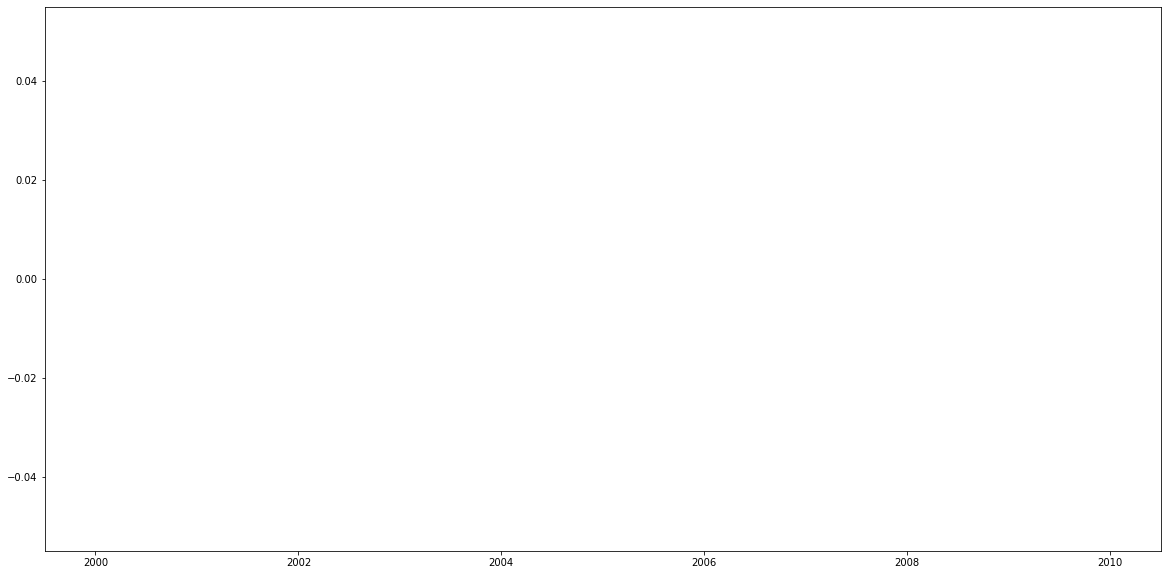

In [135]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df, x='visit_date', y='visitors', estimator=sum)
plt.show()

#### 요일별

In [ ]:
m = ['Monday', 'Tuesday', 'Thursday', 'Wednesday','Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(20,10))
sns.barplot(data = air_visit_df, x='day_of_week', y='visitors', order=m)
plt.show()

#### 월별

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(data = air_visit_df, x='visit_month', y='visitors')
plt.show()

#### 전체 기간동안 방문자와 예약자 추이

In [ ]:
air_reserve_df = split_date_time(air_reserve)
air_reserve_df

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df, x='visit_date', y='visitors', estimator=sum)
sns.lineplot(data = air_reserve_df, x='visit_date', y='reserve_visitors', color='r', estimator=sum)
plt.show()

### 2016년도 추이 확인

### 예약자 수

#### air

In [ ]:
air_reserve_df = split_date_time(air_reserve)
air_reserve_df.head()

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_reserve_df[air_reserve_df.visit_year==2016], x='visit_date', y='reserve_visitors', estimator=sum)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_reserve_df.loc[(air_reserve_df['visit_year'] == 2016) & (air_reserve_df['visit_month'] == 1)], x='visit_date', y='reserve_visitors', estimator=sum)
plt.show()

#### hpg

In [ ]:
hpg_reserve_df = split_date_time(hpg_reserve)
hpg_reserve_df.head()

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(data = hpg_reserve_df[hpg_reserve_df.visit_year==2016], x='visit_date', y='reserve_visitors', estimator=sum)
plt.show()

### 방문자 수

In [ ]:
air_visit_df = split_date_time(air_visit_data)
air_visit_df['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])
air_visit_df.head()

In [ ]:
air_visit_df.loc[air_visit_df.visit_year==2016]

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df[air_visit_df.visit_year==2016], x='visit_date', y='visitors', estimator=sum)
plt.show()

##### 한달 기간 시각화

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df.loc[(air_visit_df['visit_year'] == 2016) & (air_visit_df['visit_month'] == 1)], x='visit_date', y='visitors', estimator=sum)
plt.show()

##### 1주 기간 시각화

In [ ]:
air_visit_df['visit_week'] = air_visit_df['visit_date'].map(lambda x : date.isocalendar()[1])

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(data = air_visit_df.loc[(air_visit_df['visit_year'] == 2016) & (air_visit_df['visit_month'] == 1) & (air_visit_df['visit_week'] == 2)], x='visit_date', y='visitors', estimator=sum)
plt.show()

In [ ]:
from folium.plugins import MarkerCluster

df = final_df.loc[:, ['air_store_id', 'genre', 'latitude', 'longitude']]
df = df.drop_duplicates()
df.reset_index(inplace=True)

map = folium.Map([busan_location['latitude'].mean(),busan_location['longitude'].mean()],zoom_start=7)

list1=[]
list2=[]
marker_cluster = MarkerCluster().add_to(map)

for a in busan_location.index:
    folium.Marker(location = [busan_location.loc[a,"latitude"],busan_location.loc[a,"longitude"]],
                  popup=busan_location.loc[a,"air_store_id"]).add_to(marker_cluster)
    list1.append(busan_location.loc[a,"latitude"])
    list2.append(busan_location.loc[a,"longitude"])

map

## Feature 찾기

In [95]:
# file load
file = area.copy()
target_name = 'visitors'
no_need_features = ['air_store_id', 'visit_date']
category_features = ['genre', 'area_name', 'day_of_week', 'holiday_flg']

In [96]:
# arrange X and y
file.drop(no_need_features, axis=1, inplace=True)
y_target = file[target_name]
X_features = file.drop([target_name],axis=1,inplace=False)

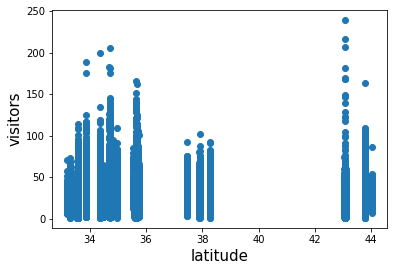

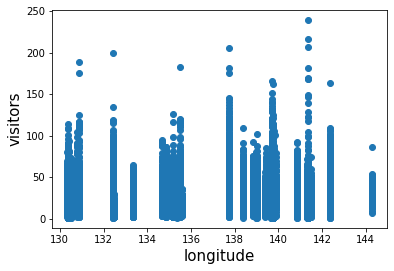

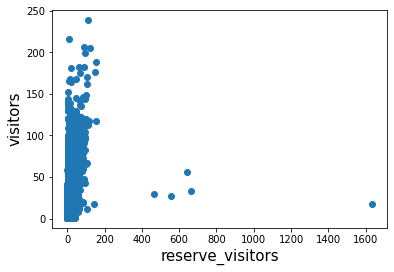

In [97]:

# visualize data to find outliers
for feature in X_features.drop(category_features, axis=1, inplace=False):
    plt.scatter(x = file[feature], y = y_target)
    plt.ylabel(target_name, fontsize=15)
    plt.xlabel(feature, fontsize=15)
    plt.show()

In [99]:
# remove outlier -> 예약자수가 400명 이상인 경우 제거
outlier_name = 'reserve_visitors'
cond1 = file[outlier_name] > 400
outlier_index = X_features[cond1].index
print('Outlier index :', outlier_index.values)
print('X_feature shape before Outlier is removed:', X_features.shape)
X_features.drop(outlier_index , axis=0, inplace=True)
y_target.drop(outlier_index, axis=0, inplace=True)
print('X_feature shape after Outlier is removed:', X_features.shape)

Outlier index : [ 2601  2602  2603  2604 12225]
X_feature shape before Outlier is removed: (28064, 7)
X_feature shape after Outlier is removed: (28059, 7)


In [102]:
from scipy.stats import skew

# 피처의 왜곡정도 파악 -> 1 이상이면 정규화 (하지만 여기서는 위도 경도 모두 정규화)
non_category_features_index = X_features.drop(category_features, axis=1, inplace=False).dtypes.index
skew_features = X_features[non_category_features_index].apply(lambda x : skew(x))
print(skew_features.sort_values(ascending=False))

skew_features_need_change = skew_features
X_features[skew_features_need_change.index] = np.log1p(X_features[skew_features_need_change.index])
X_features

reserve_visitors    2.07550
latitude            1.78503
longitude          -0.58601
dtype: float64


,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg
0,Dining bar,Musashino-shi,3.60326,4.94568,2.56495,Saturday,0
1,Cafe/Sweets,Hamamatsu-shi,3.57546,4.93250,1.09861,Monday,0
2,Cafe/Sweets,Hamamatsu-shi,3.57546,4.93250,1.38629,Friday,0
3,Cafe/Sweets,Hamamatsu-shi,3.57546,4.93250,3.25810,Saturday,0
4,Cafe/Sweets,Hamamatsu-shi,3.57546,4.93250,1.79176,Sunday,0
...,...,...,...,...,...,...,...
28059,Izakaya,Niigata-shi,3.66033,4.94144,1.09861,Friday,0
28060,Izakaya,Niigata-shi,3.66033,4.94144,3.04452,Saturday,0
28061,Izakaya,Niigata-shi,3.66033,4.94144,1.94591,Wednesday,0
28062,Izakaya,Niigata-shi,3.66033,4.94144,3.36730,Saturday,0


In [104]:
# y 값도 정규화
y_target_log = np.log1p(y_target)
# print(y_target)
# print(y_target_log)

In [106]:
# sample_submission 데이터 전처리 -> one-hot encoding 시 같은 카테고리로 만들기 위해

# store_id, date 생성
# sample_submission_df.head()
temp = sample_submission.copy()
temp['store_id'] = temp['id'].str.slice(start=0, stop=20)
temp['date'] = temp['id'].str.slice(start=21, stop=31)
temp = temp.drop(['visitors'], axis='columns')
temp

,id,store_id,date
0,air_00a91d42b08b08d9_2017-04-23,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,air_00a91d42b08b08d9,2017-04-25
3,air_00a91d42b08b08d9_2017-04-26,air_00a91d42b08b08d9,2017-04-26
4,air_00a91d42b08b08d9_2017-04-27,air_00a91d42b08b08d9,2017-04-27
...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,air_fff68b929994bfbd,2017-05-27
32015,air_fff68b929994bfbd_2017-05-28,air_fff68b929994bfbd,2017-05-28
32016,air_fff68b929994bfbd_2017-05-29,air_fff68b929994bfbd,2017-05-29
32017,air_fff68b929994bfbd_2017-05-30,air_fff68b929994bfbd,2017-05-30


In [107]:
# 요일, 휴일 추가
temp2 = pd.merge(temp, date_info, left_on='date', right_on='calendar_date')
temp2 = temp2.drop(['date', 'calendar_date'], axis='columns')
temp2

,id,store_id,day_of_week,holiday_flg
0,air_00a91d42b08b08d9_2017-04-23,air_00a91d42b08b08d9,Sunday,0
1,air_0164b9927d20bcc3_2017-04-23,air_0164b9927d20bcc3,Sunday,0
2,air_0241aa3964b7f861_2017-04-23,air_0241aa3964b7f861,Sunday,0
3,air_0328696196e46f18_2017-04-23,air_0328696196e46f18,Sunday,0
4,air_034a3d5b40d5b1b1_2017-04-23,air_034a3d5b40d5b1b1,Sunday,0
...,...,...,...,...
32014,air_fea5dc9594450608_2017-05-31,air_fea5dc9594450608,Wednesday,0
32015,air_fee8dcf4d619598e_2017-05-31,air_fee8dcf4d619598e,Wednesday,0
32016,air_fef9ccb3ba0da2f7_2017-05-31,air_fef9ccb3ba0da2f7,Wednesday,0
32017,air_ffcc2d5087e1b476_2017-05-31,air_ffcc2d5087e1b476,Wednesday,0


In [110]:

# 장르, 지역, 위도, 경도 추가
temp3 = pd.merge(temp2, air_store_info, left_on='store_id', right_on='air_store_id')
temp3 = temp3.drop(['air_store_id', 'store_id'], axis='columns')
temp3 = temp3.rename(columns = {"air_genre_name":"genre", "air_area_name": "area_name"}, inplace = False)
temp3['genre'] = temp3['genre'].replace('Asian', 'Other')
temp3['genre'] = temp3['genre'].replace('International cuisine', 'Other')
temp3['area_name'] = temp3['area_name'].str.split(' ').str[0]
temp3 = temp3.sort_values(by=['id'], axis=0)
temp3

,id,day_of_week,holiday_flg,genre,area_name,latitude,longitude
0,air_00a91d42b08b08d9_2017-04-23,Sunday,0,Italian/French,Tōkyō-to,35.69400,139.75360
1,air_00a91d42b08b08d9_2017-04-24,Monday,0,Italian/French,Tōkyō-to,35.69400,139.75360
2,air_00a91d42b08b08d9_2017-04-25,Tuesday,0,Italian/French,Tōkyō-to,35.69400,139.75360
3,air_00a91d42b08b08d9_2017-04-26,Wednesday,0,Italian/French,Tōkyō-to,35.69400,139.75360
4,air_00a91d42b08b08d9_2017-04-27,Thursday,0,Italian/French,Tōkyō-to,35.69400,139.75360
...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,Saturday,0,Bar/Cocktail,Tōkyō-to,35.70815,139.66629
32015,air_fff68b929994bfbd_2017-05-28,Sunday,0,Bar/Cocktail,Tōkyō-to,35.70815,139.66629
32016,air_fff68b929994bfbd_2017-05-29,Monday,0,Bar/Cocktail,Tōkyō-to,35.70815,139.66629
32017,air_fff68b929994bfbd_2017-05-30,Tuesday,0,Bar/Cocktail,Tōkyō-to,35.70815,139.66629


In [111]:
# test file 값 정규화
non_category_features_index = temp3.drop(category_features+['id'], axis=1, inplace=False).dtypes.index
skew_features = temp3[non_category_features_index].apply(lambda x : skew(x))
print(skew_features.sort_values(ascending=False))
skew_features_need_change = skew_features
temp3[skew_features_need_change.index] = np.log1p(temp3[skew_features_need_change.index])
temp3

latitude     2.68423
longitude   -0.93461
dtype: float64


,id,day_of_week,holiday_flg,genre,area_name,latitude,longitude
0,air_00a91d42b08b08d9_2017-04-23,Sunday,0,Italian/French,Tōkyō-to,3.60261,4.94701
1,air_00a91d42b08b08d9_2017-04-24,Monday,0,Italian/French,Tōkyō-to,3.60261,4.94701
2,air_00a91d42b08b08d9_2017-04-25,Tuesday,0,Italian/French,Tōkyō-to,3.60261,4.94701
3,air_00a91d42b08b08d9_2017-04-26,Wednesday,0,Italian/French,Tōkyō-to,3.60261,4.94701
4,air_00a91d42b08b08d9_2017-04-27,Thursday,0,Italian/French,Tōkyō-to,3.60261,4.94701
...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,Saturday,0,Bar/Cocktail,Tōkyō-to,3.60300,4.94639
32015,air_fff68b929994bfbd_2017-05-28,Sunday,0,Bar/Cocktail,Tōkyō-to,3.60300,4.94639
32016,air_fff68b929994bfbd_2017-05-29,Monday,0,Bar/Cocktail,Tōkyō-to,3.60300,4.94639
32017,air_fff68b929994bfbd_2017-05-30,Tuesday,0,Bar/Cocktail,Tōkyō-to,3.60300,4.94639


In [113]:
# X_features와 submission file concat
frames = [X_features, temp3]
concated = pd.concat(frames, keys=['x','y'])
concated

genre  ...                               id
x 0        Dining bar  ...                              NaN
  1       Cafe/Sweets  ...                              NaN
  2       Cafe/Sweets  ...                              NaN
  3       Cafe/Sweets  ...                              NaN
  4       Cafe/Sweets  ...                              NaN
...               ...  ...                              ...
y 32014  Bar/Cocktail  ...  air_fff68b929994bfbd_2017-05-27
  32015  Bar/Cocktail  ...  air_fff68b929994bfbd_2017-05-28
  32016  Bar/Cocktail  ...  air_fff68b929994bfbd_2017-05-29
  32017  Bar/Cocktail  ...  air_fff68b929994bfbd_2017-05-30
  32018  Bar/Cocktail  ...  air_fff68b929994bfbd_2017-05-31

[60078 rows x 8 columns]

In [115]:
# 카테고리형 피쳐 one-hot encoding 후 train data와 제출용 data 분리
ohe = pd.get_dummies(concated, columns=category_features)
X_features_ohe = ohe.loc['x']

X_features_ohe = X_features_ohe.drop(['id'], axis='columns')
test_x = ohe.loc['y'].drop(['reserve_visitors'], axis='columns')
test_x = test_x.sort_values(by=['id'], axis=0)
# test_x_df

X_features_ohe

,latitude,longitude,reserve_visitors,genre_Bar/Cocktail,genre_Cafe/Sweets,genre_Creative cuisine,genre_Dining bar,genre_Italian/French,genre_Izakaya,genre_Japanese food,genre_Karaoke/Party,genre_Okonomiyaki/Monja/Teppanyaki,genre_Other,genre_Western food,genre_Yakiniku/Korean food,area_name_Abashiri-shi,area_name_Amagasaki-shi,area_name_Asahikawa-shi,area_name_Chiyoda-ku,area_name_Chūō-ku,area_name_Edogawa-ku,area_name_Fukuoka-ken,area_name_Fukuoka-shi,area_name_Fukuyama-shi,area_name_Hamamatsu-shi,area_name_Higashiōsaka-shi,area_name_Himeji-shi,area_name_Hiroshima-ken,area_name_Hiroshima-shi,area_name_Hokkaidō,area_name_Hyōgo-ken,area_name_Itabashi-ku,area_name_Kakogawa-shi,area_name_Katsushika-ku,area_name_Kitakyūshū-shi,area_name_Kurume-shi,area_name_Kōbe-shi,area_name_Kōtō-ku,area_name_Machida-shi,area_name_Meguro-ku,area_name_Minato-ku,area_name_Miyagi-ken,area_name_Musashino-shi,area_name_Nagaoka-shi,area_name_Nakano-ku,area_name_Nerima-ku,area_name_Niigata-ken,area_name_Niigata-shi,area_name_Nishinomiya-shi,area_name_Sapporo-shi,area_name_Sendai-shi,area_name_Setagaya-ku,area_name_Shibuya-ku,area_name_Shinagawa-ku,area_name_Shinjuku-ku,area_name_Shizuoka-ken,area_name_Shizuoka-shi,area_name_Suginami-ku,area_name_Tachikawa-shi,area_name_Taitō-ku,area_name_Takarazuka-shi,area_name_Toshima-ku,area_name_Tōkyō-to,area_name_Yame-shi,area_name_Ōsaka-fu,area_name_Ōsaka-shi,area_name_Ōta-ku,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_0,holiday_flg_1
0,3.60326,4.94568,2.56495,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,3.57546,4.93250,1.09861,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,3.57546,4.93250,1.38629,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,3.57546,4.93250,3.25810,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,3.57546,4.93250,1.79176,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28059,3.66033,4.94144,1.09861,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
28060,3.66033,4.94144,3.04452,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
28061,3.66033,4.94144,1.94591,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
28062,3.66033,4.94144,3.36730,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [116]:
X_features_final = X_features_ohe.drop(['reserve_visitors'], axis='columns')
X_features_final

,latitude,longitude,genre_Bar/Cocktail,genre_Cafe/Sweets,genre_Creative cuisine,genre_Dining bar,genre_Italian/French,genre_Izakaya,genre_Japanese food,genre_Karaoke/Party,genre_Okonomiyaki/Monja/Teppanyaki,genre_Other,genre_Western food,genre_Yakiniku/Korean food,area_name_Abashiri-shi,area_name_Amagasaki-shi,area_name_Asahikawa-shi,area_name_Chiyoda-ku,area_name_Chūō-ku,area_name_Edogawa-ku,area_name_Fukuoka-ken,area_name_Fukuoka-shi,area_name_Fukuyama-shi,area_name_Hamamatsu-shi,area_name_Higashiōsaka-shi,area_name_Himeji-shi,area_name_Hiroshima-ken,area_name_Hiroshima-shi,area_name_Hokkaidō,area_name_Hyōgo-ken,area_name_Itabashi-ku,area_name_Kakogawa-shi,area_name_Katsushika-ku,area_name_Kitakyūshū-shi,area_name_Kurume-shi,area_name_Kōbe-shi,area_name_Kōtō-ku,area_name_Machida-shi,area_name_Meguro-ku,area_name_Minato-ku,area_name_Miyagi-ken,area_name_Musashino-shi,area_name_Nagaoka-shi,area_name_Nakano-ku,area_name_Nerima-ku,area_name_Niigata-ken,area_name_Niigata-shi,area_name_Nishinomiya-shi,area_name_Sapporo-shi,area_name_Sendai-shi,area_name_Setagaya-ku,area_name_Shibuya-ku,area_name_Shinagawa-ku,area_name_Shinjuku-ku,area_name_Shizuoka-ken,area_name_Shizuoka-shi,area_name_Suginami-ku,area_name_Tachikawa-shi,area_name_Taitō-ku,area_name_Takarazuka-shi,area_name_Toshima-ku,area_name_Tōkyō-to,area_name_Yame-shi,area_name_Ōsaka-fu,area_name_Ōsaka-shi,area_name_Ōta-ku,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_0,holiday_flg_1
0,3.60326,4.94568,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,3.57546,4.93250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,3.57546,4.93250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,3.57546,4.93250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,3.57546,4.93250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28059,3.66033,4.94144,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
28060,3.66033,4.94144,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
28061,3.66033,4.94144,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
28062,3.66033,4.94144,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


## 모델 학습

In [121]:
# declare the model
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()
en_reg = ElasticNet()
dt_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()
gbm_reg = GradientBoostingRegressor()
xgb_reg = XGBRegressor()
lgbm_reg = LGBMRegressor()

In [122]:
# 최적의 하이퍼 파라미터를 리턴
def get_best_params(model, params, X, y):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_log_error', cv=5)
    grid_model.fit(X, y)
    rmsle = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV best average RMSLE value: {1}, best alpha:{2}'.format(model.__class__.__name__,np.round(rmsle, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [ ]:
# find best parameters
# ridge_params = { 'alpha':[130, 150, 170]}
# lasso_params = { 'alpha':[0.003, 0.004, 0.005]}
# en_params = { 'alpha':[0.001, 0.005, 0.01, 0.05, 0.07, 0.1]}
# dt_params = {'max_depth':[1,2,3,4,5,6]}
#rf_params = {'n_estimators':[200], 'max_depth' : [5], 'min_samples_leaf' : [2], 'min_samples_split' : [5]}

# gbm_params = {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators':[100, 500, 700], 'subsample': [0.01, 0.05, 0.1]}
# xgb_params = {'colsample_bytree': [1], 'eta': [0.1], 'max_depth': [3], 'min_child_weight': [3], 'n_estimators':[120]}

# best_rige = get_best_params(ridge_reg, ridge_params, X_features_ohe, y_target_log)
# best_lasso = get_best_params(lasso_reg, lasso_params, X_features_ohe, y_target_log)
# best_en = get_best_params(en_reg, en_params, X_features_ohe, y_target_log)
# best_dt = get_best_params(dt_reg, dt_params, X_features_ohe, y_target_log)
# best_rf = get_best_params(rf_reg, rf_params, X_features_ohe, y_target_log)

# best_gbm = get_best_params(gbm_reg, gbm_params, X_features_ohe, y_target_log)
# best_xgb = get_best_params(xgb_reg, xgb_params, X_features_ohe, y_target_log)

In [123]:
# define the model
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=170)
lasso_reg = Lasso(alpha=0.004)
en_reg = ElasticNet(alpha=0.01)
dt_reg = DecisionTreeRegressor(max_depth=4)
rf_reg = RandomForestRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, n_jobs=-1)
gbm_reg = GradientBoostingRegressor(learning_rate=0.02, n_estimators=500, subsample=0.05)
xgb_reg = XGBRegressor(eta=0.1, min_child_weight=3, max_depth=3, n_estimators=120)
lgbm_reg = LGBMRegressor(learning_rate=0.03, max_depth=3, min_child_samples=10, n_estimators=1000, num_leaves=3)

In [124]:
# split train/test data
X_train, X_test, y_train, y_test = train_test_split(X_features_final, y_target_log, test_size=0.2, random_state=0)

In [125]:
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    # scale back by expm1() if the predicted result is predicted by log-translated data
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
    print('\n###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
    
# calculate MAE, MSE, RMSE, RMSLE
def evaluate_regr(y, pred):
    mae_val = mean_absolute_error(y, pred)
    mse_val = mean_squared_error(y, pred)
    rmse_val = rmse(y, pred)
    rmsle_val = rmsle(y,pred)
    r2_val = r2_score(y, pred)
    print('MAE: {0:.3F}, MSE: {1:.3F}, RMSE: {2:.3F}, RMSLE: {3:.3F}, R2: {4:.3F}'.format(mae_val, mse_val, rmse_val, rmsle_val, r2_val))

# calculate RMSLE using log1p(), not log() because of the NaN issue 
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# calculate RMSE using mean_square_error() of Scikit-learn 
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

In [126]:
# linear regression models
models_linear = [lr_reg, ridge_reg, lasso_reg, en_reg]
for model in models_linear:
    get_model_predict(model,X_train, X_test, y_train, y_test)


### LinearRegression ###
MAE: 11.997, MSE: 283.511, RMSE: 16.838, RMSLE: 0.627, R2: 0.128

### Ridge ###
MAE: 12.053, MSE: 288.543, RMSE: 16.987, RMSLE: 0.629, R2: 0.112

### Lasso ###
MAE: 12.307, MSE: 299.711, RMSE: 17.312, RMSLE: 0.641, R2: 0.078

### ElasticNet ###
MAE: 12.399, MSE: 304.794, RMSE: 17.458, RMSLE: 0.646, R2: 0.062


In [127]:
# regression tree models
models_tree = [dt_reg, rf_reg, gbm_reg, xgb_reg]
# models_tree = [dt_reg]
for model in models_tree:
    get_model_predict(model,X_train, X_test, y_train, y_test)


### DecisionTreeRegressor ###
MAE: 12.430, MSE: 308.252, RMSE: 17.557, RMSLE: 0.650, R2: 0.052

### RandomForestRegressor ###
MAE: 12.210, MSE: 298.711, RMSE: 17.283, RMSLE: 0.638, R2: 0.081

### GradientBoostingRegressor ###
MAE: 11.269, MSE: 259.111, RMSE: 16.097, RMSLE: 0.591, R2: 0.203
[13:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

### XGBRegressor ###
MAE: 11.464, MSE: 268.742, RMSE: 16.393, RMSLE: 0.600, R2: 0.173


##  모델 평가

In [120]:
test_x

,latitude,longitude,id,genre_Bar/Cocktail,genre_Cafe/Sweets,genre_Creative cuisine,genre_Dining bar,genre_Italian/French,genre_Izakaya,genre_Japanese food,genre_Karaoke/Party,genre_Okonomiyaki/Monja/Teppanyaki,genre_Other,genre_Western food,genre_Yakiniku/Korean food,area_name_Abashiri-shi,area_name_Amagasaki-shi,area_name_Asahikawa-shi,area_name_Chiyoda-ku,area_name_Chūō-ku,area_name_Edogawa-ku,area_name_Fukuoka-ken,area_name_Fukuoka-shi,area_name_Fukuyama-shi,area_name_Hamamatsu-shi,area_name_Higashiōsaka-shi,area_name_Himeji-shi,area_name_Hiroshima-ken,area_name_Hiroshima-shi,area_name_Hokkaidō,area_name_Hyōgo-ken,area_name_Itabashi-ku,area_name_Kakogawa-shi,area_name_Katsushika-ku,area_name_Kitakyūshū-shi,area_name_Kurume-shi,area_name_Kōbe-shi,area_name_Kōtō-ku,area_name_Machida-shi,area_name_Meguro-ku,area_name_Minato-ku,area_name_Miyagi-ken,area_name_Musashino-shi,area_name_Nagaoka-shi,area_name_Nakano-ku,area_name_Nerima-ku,area_name_Niigata-ken,area_name_Niigata-shi,area_name_Nishinomiya-shi,area_name_Sapporo-shi,area_name_Sendai-shi,area_name_Setagaya-ku,area_name_Shibuya-ku,area_name_Shinagawa-ku,area_name_Shinjuku-ku,area_name_Shizuoka-ken,area_name_Shizuoka-shi,area_name_Suginami-ku,area_name_Tachikawa-shi,area_name_Taitō-ku,area_name_Takarazuka-shi,area_name_Toshima-ku,area_name_Tōkyō-to,area_name_Yame-shi,area_name_Ōsaka-fu,area_name_Ōsaka-shi,area_name_Ōta-ku,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_0,holiday_flg_1
0,3.60261,4.94701,air_00a91d42b08b08d9_2017-04-23,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,3.60261,4.94701,air_00a91d42b08b08d9_2017-04-24,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2,3.60261,4.94701,air_00a91d42b08b08d9_2017-04-25,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
3,3.60261,4.94701,air_00a91d42b08b08d9_2017-04-26,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
4,3.60261,4.94701,air_00a91d42b08b08d9_2017-04-27,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32014,3.60300,4.94639,air_fff68b929994bfbd_2017-05-27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
32015,3.60300,4.94639,air_fff68b929994bfbd_2017-05-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
32016,3.60300,4.94639,air_fff68b929994bfbd_2017-05-29,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
32017,3.60300,4.94639,air_fff68b929994bfbd_2017-05-30,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0


In [128]:
# test data의 index를 id로 설정하여 순서가 바뀌지 않도록 함
test_x2 = test_x.set_index('id',inplace = False)
test_x2

,latitude,longitude,genre_Bar/Cocktail,genre_Cafe/Sweets,genre_Creative cuisine,genre_Dining bar,genre_Italian/French,genre_Izakaya,genre_Japanese food,genre_Karaoke/Party,genre_Okonomiyaki/Monja/Teppanyaki,genre_Other,genre_Western food,genre_Yakiniku/Korean food,area_name_Abashiri-shi,area_name_Amagasaki-shi,area_name_Asahikawa-shi,area_name_Chiyoda-ku,area_name_Chūō-ku,area_name_Edogawa-ku,area_name_Fukuoka-ken,area_name_Fukuoka-shi,area_name_Fukuyama-shi,area_name_Hamamatsu-shi,area_name_Higashiōsaka-shi,area_name_Himeji-shi,area_name_Hiroshima-ken,area_name_Hiroshima-shi,area_name_Hokkaidō,area_name_Hyōgo-ken,area_name_Itabashi-ku,area_name_Kakogawa-shi,area_name_Katsushika-ku,area_name_Kitakyūshū-shi,area_name_Kurume-shi,area_name_Kōbe-shi,area_name_Kōtō-ku,area_name_Machida-shi,area_name_Meguro-ku,area_name_Minato-ku,area_name_Miyagi-ken,area_name_Musashino-shi,area_name_Nagaoka-shi,area_name_Nakano-ku,area_name_Nerima-ku,area_name_Niigata-ken,area_name_Niigata-shi,area_name_Nishinomiya-shi,area_name_Sapporo-shi,area_name_Sendai-shi,area_name_Setagaya-ku,area_name_Shibuya-ku,area_name_Shinagawa-ku,area_name_Shinjuku-ku,area_name_Shizuoka-ken,area_name_Shizuoka-shi,area_name_Suginami-ku,area_name_Tachikawa-shi,area_name_Taitō-ku,area_name_Takarazuka-shi,area_name_Toshima-ku,area_name_Tōkyō-to,area_name_Yame-shi,area_name_Ōsaka-fu,area_name_Ōsaka-shi,area_name_Ōta-ku,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_0,holiday_flg_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
air_00a91d42b08b08d9_2017-04-23,3.60261,4.94701,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
air_00a91d42b08b08d9_2017-04-24,3.60261,4.94701,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
air_00a91d42b08b08d9_2017-04-25,3.60261,4.94701,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
air_00a91d42b08b08d9_2017-04-26,3.60261,4.94701,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
air_00a91d42b08b08d9_2017-04-27,3.60261,4.94701,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
air_fff68b929994bfbd_2017-05-27,3.60300,4.94639,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
air_fff68b929994bfbd_2017-05-28,3.60300,4.94639,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
air_fff68b929994bfbd_2017-05-29,3.60300,4.94639,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0


In [129]:
X_features_final

,latitude,longitude,genre_Bar/Cocktail,genre_Cafe/Sweets,genre_Creative cuisine,genre_Dining bar,genre_Italian/French,genre_Izakaya,genre_Japanese food,genre_Karaoke/Party,genre_Okonomiyaki/Monja/Teppanyaki,genre_Other,genre_Western food,genre_Yakiniku/Korean food,area_name_Abashiri-shi,area_name_Amagasaki-shi,area_name_Asahikawa-shi,area_name_Chiyoda-ku,area_name_Chūō-ku,area_name_Edogawa-ku,area_name_Fukuoka-ken,area_name_Fukuoka-shi,area_name_Fukuyama-shi,area_name_Hamamatsu-shi,area_name_Higashiōsaka-shi,area_name_Himeji-shi,area_name_Hiroshima-ken,area_name_Hiroshima-shi,area_name_Hokkaidō,area_name_Hyōgo-ken,area_name_Itabashi-ku,area_name_Kakogawa-shi,area_name_Katsushika-ku,area_name_Kitakyūshū-shi,area_name_Kurume-shi,area_name_Kōbe-shi,area_name_Kōtō-ku,area_name_Machida-shi,area_name_Meguro-ku,area_name_Minato-ku,area_name_Miyagi-ken,area_name_Musashino-shi,area_name_Nagaoka-shi,area_name_Nakano-ku,area_name_Nerima-ku,area_name_Niigata-ken,area_name_Niigata-shi,area_name_Nishinomiya-shi,area_name_Sapporo-shi,area_name_Sendai-shi,area_name_Setagaya-ku,area_name_Shibuya-ku,area_name_Shinagawa-ku,area_name_Shinjuku-ku,area_name_Shizuoka-ken,area_name_Shizuoka-shi,area_name_Suginami-ku,area_name_Tachikawa-shi,area_name_Taitō-ku,area_name_Takarazuka-shi,area_name_Toshima-ku,area_name_Tōkyō-to,area_name_Yame-shi,area_name_Ōsaka-fu,area_name_Ōsaka-shi,area_name_Ōta-ku,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_0,holiday_flg_1
0,3.60326,4.94568,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,3.57546,4.93250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,3.57546,4.93250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,3.57546,4.93250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,3.57546,4.93250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28059,3.66033,4.94144,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
28060,3.66033,4.94144,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
28061,3.66033,4.94144,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
28062,3.66033,4.94144,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
# model define
# model = Ridge(alpha=170)
# model.fit(x_temp_features, y_target)

In [ ]:
# predict
# predict_value = model.predict(test_x2_df)
# print("**Single Model**")
# test_y = []
# for x in predict_value:
#     test_y.append(round(x,1))
# final_sub_df = sample_submission_df.copy()
# final_sub_df['visitors'] = test_y
# final_sub_df

In [130]:
# mixed model
model1 = LinearRegression()
model2 = GradientBoostingRegressor(learning_rate=0.02, n_estimators=500, subsample=0.05)
# model3 = xgb_reg = XGBRegressor(eta=0.1, min_child_weight=3, max_depth=3, n_estimators=120)

model1.fit(X_features_final, y_target)
model2.fit(X_features_final, y_target)
# model3.fit(X_features_final, y_target)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.02, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.05, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [131]:
# mixed model
pred1 = model1.predict(test_x2)
pred2 = model2.predict(test_x2)
# pred3 = model3.predict(test_x2_df)

pred = 0.3 * pred2 + 0.7 * pred2
test_y2 = []
for x in pred:
    test_y2.append(round(x,3))

final_sub = sample_submission.copy()
final_sub['visitors'] = test_y2
final_sub

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,26.27000
1,air_00a91d42b08b08d9_2017-04-24,18.78600
2,air_00a91d42b08b08d9_2017-04-25,20.56200
3,air_00a91d42b08b08d9_2017-04-26,21.98800
4,air_00a91d42b08b08d9_2017-04-27,21.43000
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,26.99900
32015,air_fff68b929994bfbd_2017-05-28,22.29000
32016,air_fff68b929994bfbd_2017-05-29,13.32000
32017,air_fff68b929994bfbd_2017-05-30,15.11700


In [132]:

final_sub.to_csv('/aiffel/aiffel/Hackerton/1/submission.csv', sep=',', index = False)

FileNotFoundError: ignored